In [1]:
#import 
import pandas as pd 
import numpy as np 
import seaborn as sns 
from requests import get
import fmpclient
from collections import defaultdict
import matplotlib.pyplot as plt 

In [2]:
api = fmpclient.FMPClient()

In [3]:
def url_import(stock_list, info_type,params = {'datatype': 'json'}): 
    
    
    #dict_info = dict_maker(stock_list)
    dict_info = defaultdict(list)
    err_list = []
    url_list = ['''https://fmpcloud.io/api/v3/{info_type}/{stock}?apikey=cb3b0c371586d9ce915d359479fe1c81'''
                .format(info_type=info_type, stock = stock) 
    for stock in stock_list]

    print(url_list[0])
    for url, stock in zip(url_list,stock_list):
        try:
            #import financial ratios
            financial = api.requester.GET(url, params)
           
        
            for period_dict in financial: 

                for key, value in period_dict.items():
                    

                   # if key == 'date': 
                    #    dict_info[stock]['date'].append(value)
                    
                    dict_info[key].append(value)
        
        except: 
            err_list.append(stock)
            pass 
        
        
    
            
    return dict_info, err_list 

In [4]:
def url_import_latest(stock_list, info_type,params = {'datatype': 'json'}): 
    
    
    #dict_info = dict_maker(stock_list)
    dict_info = defaultdict(list)
    err_list = []
    url_list = ['''https://fmpcloud.io/api/v3/{info_type}/{stock}?apikey=cb3b0c371586d9ce915d359479fe1c81'''
                .format(info_type=info_type, stock = stock) 
    for stock in stock_list]

    print(url_list[0])
    for url, stock in zip(url_list,stock_list):
        try:
            #import financial ratios
            financial = api.requester.GET(url, params)
           
        

            for key, value in financial[0].items():
                
                    

                   # if key == 'date': 
                    #    dict_info[stock]['date'].append(value)
                    
                dict_info[key].append(value)
        
        except: 
            err_list.append(stock)
            pass 
        
        
    
            
    return dict_info, err_list

In [1628]:
def intrinsic_cash(df,cf_ests, grs,drs,n):
    iv_dict = defaultdict(list)
    shares = df['shares'].values[-1]
    lgr = 0.03
    for cf_est in cf_ests: 
        for gr in grs: 
            iv_dict['{},{}%'.format(cf_est/1000,gr*100)] = []
            for dr in drs: 
                
                fcfn = [ cf_est * (1 + gr)**i for i in range(1,n+1)]
                dfn = [(1+dr)**i for i in range(1,n+1)]
                dcf = sum([fcf/df for fcf, df in zip(fcfn,dfn)])
                dpcf = ((cf_est * (1 + gr)**(n+1) * (1 + lgr)) / (dr - lgr)) * (1 / (1 + dr)**(n+1))
                iv = (dcf + dpcf) / shares
                iv_dict['{},{}%'.format(cf_est/1000,gr*100)].append(iv)
    return iv_dict

In [1553]:
def intrinsic_earn(df,earn_ests,drs,gr,roc,short = False):
    iv_dict = defaultdict(list)
    cash = (df['cashAndCashEquivalents'] - (df['revenue'] *0.01)) 
    if short == True:
        cash = cash + 0.4 * df['shortTermInvestments']
    
    cash = cash.values[-1]
    shares = df['shares'].values[-1]
    debt = df['totalDebt'].values[-1]
    for earn in earn_ests: 
        iv_dict['{}'.format(earn)] = []
        for dr in drs: 
            epv = (earn / dr) 
            epv = epv + (cash)
            epv = epv - debt
            iv = epv / shares
            capital = iv / (roc/dr)
            pv = capital *((roc-gr) / (dr - gr))
            mof = pv/iv 
            iv_dict['{}'.format(earn)].append((iv,mof))
    return iv_dict
        

In [6]:
def intrn_avg(dict_iv): 
    dict_final = defaultdict(float)
    for key, value in dict_iv.items():
        dict_final[key] = np.mean(value)
    return dict_final
        

In [7]:
def intrinsic_bk(avg_div_yr, pbvPersh_est, gr,dr,n): 
    fbv = pbvPersh_est * (1 + gr)**n 
    div = avg_div_yr * ((1 - (1 / (1 + dr)**n)) / dr)
    return div + (fbv / (1 + dr)**n)

In [8]:
def annual_growth(f,i,n): 
    return ((f/i)**(1/n) - 1)

In [1213]:
def price_ratios(df): 
    df['pe'] = df['stockPrice'] / df.eps 
    df['ps'] = df['stockPrice']  / (df.revenue / df .shares)
    df['pb'] = df['stockPrice'] / df.bv
    df['pfcf'] = df['stockPrice'] / (df['freeCashFlow'] / df['shares'])
    df['pocf'] = df['stockPrice'] / (df['operatingCashFlow'] / df['shares'])
    return df

In [1245]:
def metrics(df): 
    df['de'] =df['totalDebt'] /df['totalStockholdersEquity']
    df['curr'] = df['totalCurrentAssets'] / df['totalCurrentLiabilities']
    df['currDebt'] = df['totalCurrentAssets'] / df['totalDebt']
    df['debtRatio'] = df['totalDebt'] / df['totalAssets']
    df['ocfRatio'] = df['operatingCashFlow'] / df['revenue']
    df['fcfRatio'] = df['freeCashFlow'] / df['revenue']
    df['roe'] = df['netIncome'] / df['totalStockholdersEquity']
    df['roi'] = df['netIncome'] / df['totalAssets']
    df['rof'] = df['freeCashFlow'] / df['totalStockholdersEquity']
    df['rocf'] = df['operatingCashFlow'] / df['totalStockholdersEquity']
    df['intCov'] = df['operatingIncome'] / df['interestExpense']
    df['bv'] = df['totalStockholdersEquity'] / df['shares']
    df['div']= np.abs(df['dividendsPaid'])/df['shares']
    df['fcf'] =df['freeCashFlow'] /df['shares']
    df['ocf'] = df['operatingCashFlow']/ df['shares']
    df['invTurnOver'] = np.abs(df['costOfRevenue']) / df['inventory']
    df['recTurnOver'] = df['revenue'] / df['netReceivables']
    df['payTurnOver'] = np.abs(df['costOfRevenue']) / df['accountPayables']
    df['ownerCash'] = df['freeCashFlow']  / df['revenue']
    df['gcf'] = np.abs(df['netCashUsedForInvestingActivites']) / df['operatingCashFlow']
    df['rdpct'] = df['researchAndDevelopmentExpenses'] / df['revenue']
    df['smpct'] = df['sellingAndMarketingExpenses'] /df['revenue']
    df['gapct'] = df['generalAndAdministrativeExpenses'] / df['revenue']
    df['operatingAss']= df['totalAssets'] - df['totalLiabilities'] - df['cashAndCashEquivalents'] + df['totalDebt']
    df['roc'] = (df['operatingIncome']) / (df['totalStockholdersEquity'] +df['totalDebt'])

    return df 
    

In [1554]:
def earn_calc(df,short = False):
    a = (df.propertyPlantEquipmentNet / df.revenue ).median()
    b = df.operatingIncome + df.depreciationAndAmortization - 0.38 * df.operatingIncome
    b = b + df.totalOtherIncomeExpensesNet.median()
    df['mainCapEx'] = df.capitalExpenditure-(df.revenue.subtract(df.revenue.shift(1)) * a)
    df['distEarn'] = b - df['mainCapEx']
    
    df['earn'] = df['operatingIncome']
    df['earn'] = df['earn'] + df['totalOtherIncomeExpensesNet'].median()
    
    if df['rdpct'].median() >= 0.07: 
        df['earn'] = df['earn'] + df['researchAndDevelopmentExpenses'] * 0.3
    if df['smpct'].median() >= 0.07: 
        df['earn'] = df['earn'] + df['sellingAndMarketingExpenses'] *0.3
        
    if df['gapct'].median() >= 0.07:
        if  df['rdpct'].median() < 0.07 and df['smpct'].median() < 0.07:
            df['earn'] = df['earn'] + df['generalAndAdministrativeExpenses'] * 0.5
        elif df['rdpct'].median() < 0.07 or df['smpct'].median() < 0.07:
            df['earn'] = df['earn'] + df['generalAndAdministrativeExpenses'] * 0.4
        else: 
            df['earn'] = df['earn'] + df['generalAndAdministrativeExpenses'] * 0.3
    #taxes 
    df['earn'] = df['earn'] - (df['operatingIncome'] * 0.38)
    #depr amort and maintanance
    if df['mainCapEx'].median() < df['depreciationAndAmortization'].median() *0.4:
        df['earn'] = df['earn'] + df['depreciationAndAmortization'] * 0.45
        
    if df['mainCapEx'].median() >= df['depreciationAndAmortization'].median() *0.4: 
        df['earn'] = df['earn'] + df['depreciationAndAmortization'] * 0.3
    
    df['epv10'] = df['earn'] / 0.1
    df['epv10'] = df['epv10'] + (df['cashAndCashEquivalents'] - (df['revenue'] *0.01))
    if short == True:
        df['epv10'] = df['epv10']+df['shortTermInvestments'] *0.4
    
    df['epv10'] = df['epv10'] - df['totalDebt']
    df['epv10'] = df['epv10'] / df['shares']
    df['capital'] = df['bv'] + (df['totalDebt'] / df['shares'])
    df['pv10'] = df['capital'] * ((df['roe'] - 0.03) / (0.1 - 0.03))
    df['mof'] = df['pv10'] / df['epv10']
    return df

In [1211]:
def enterValue(df): 
    
    df['enterValue']= df['totalDebt'] + (df['shares'] *df['stockPrice']) - df['cashAndCashEquivalents']
    df['enterValue'] = df['enterValue'] / df['shares']
    return df


In [1327]:
def bv_adj(df,allow,invent_add,lic,subsid,tot_pct,yrs): 
    df['bv_adj'] = df['totalAssets'] + invent_add + allow
    if df['propertyPlantEquipmentNet'].median() < df['capitalExpenditure'].median() *4: 
        df['bv_adj'] = df['bv_adj'] + df['propertyPlantEquipmentNet']*0.25
    df['bv_adj'] = df['bv_adj'] + lic + subsid  
    df['bv_adj'] = df['bv_adj'] + (tot_pct * df['revenue'] *yrs) 
    df['bv_adj'] = df['bv_adj'] - df['totalLiabilities'] 
    df['bv_adj'] =df['bv_adj']/df['shares']
    return df 
    

In [1377]:
def intrin_div(div,dr,gr): 
    return div* (1 / (dr-gr))

In [11]:
import re

In [1247]:
df_t[['epv10','bv','pv10','mof','roc','roe','enterValue','capital']]

,epv10,bv,pv10,mof,roc,roe,enterValue,capital
date,,,,,,,,
2002,5.717889,0.000000,9.121084,1.595184,-0.257226,NaN,29.563714,-2.222901
2004,12.092333,5.786286,14.973363,1.238253,0.225186,0.145344,32.743571,5.369930
2005,12.585069,7.812857,15.412512,1.224666,0.210182,0.087511,33.192286,5.987701
2006,16.979079,16.505714,20.197455,1.189550,0.179302,0.063666,37.196857,9.469533
2008,43.666717,16.481000,56.681159,1.298040,0.328329,0.103591,37.877857,13.299687
2009,43.557117,13.763857,56.299680,1.292548,0.315073,0.133549,39.457000,13.824470
2010,42.918460,0.000000,32.467762,0.756499,0.063769,inf,38.754143,67.303422
2010,42.692900,15.992857,54.938858,1.286838,0.302379,0.173292,38.247143,14.118998
2011,37.453267,15.113857,24.361224,0.650443,0.055077,0.037279,37.795429,68.001367


In [1130]:
intrinsic_earn([1216],drs,df_cit.shares.values[0],5000,8118.8)

defaultdict(list,
            {'1216': [91.74693877551022,
              50.38639455782314,
              29.70612244897959]})

# final
# hospitality check 
# ruth 

In [70]:
dict_mgm_cash,errs_mgm = url_import(['MGM'], 'cash-flow-statement')
dict_mgm_balance,errs_mgm = url_import(['MGM'], 'balance-sheet-statement')
dict_mgm_income,errs_mgm = url_import(['MGM'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/MGM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/MGM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/MGM?apikey=cb3b0c371586d9ce915d359479fe1c81


In [71]:
df_mgm_cash = pd.DataFrame(dict_mgm_cash)
df_mgm_bal = pd.DataFrame(dict_mgm_balance)
df_mgm_income = pd.DataFrame(dict_mgm_income)

In [72]:
df_mgm_bal.date = df_mgm_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_mgm_cash.date = df_mgm_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_mgm_income.date = df_mgm_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [73]:
df_mgm_bal.set_index(['date'], inplace = True)
df_mgm_cash.set_index(['date'], inplace = True)
df_mgm_income.set_index(['date'], inplace = True)

In [74]:
df_mgm_cash.drop('netIncome',axis = 1, inplace = True)
df_mgm_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [75]:
df_mgm = pd.concat([df_mgm_income,df_mgm_bal,df_mgm_cash],axis = 1)

In [76]:
df_mgm.drop(['symbol','period'],axis = 1, inplace =True)

In [77]:
df_mgm['shares'] = 492E06

In [78]:
df_mgm.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [79]:
df_mgm = df_mgm/1000

In [80]:
df_mgm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_mgm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [81]:
df_mgm = df_mgm.sort_index()

In [82]:
df_mgm_main = df_mgm.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [83]:
df_mgm_main['netIncome'] = df_mgm_income['netIncome'] / 1000

In [84]:
df_mgm = metrics(df_mgm)
df_mgm = price_ratios(df_mgm, 10)

# ana

In [85]:
df_mgm[['de','debtRatio']]

,de,debtRatio
2000,2.496329,0.603189
2001,2.207484,0.573940
2002,1.989774,0.550817
2003,2.217474,0.578843
2004,2.011708,0.521122
2005,3.890293,0.653709
2006,3.436201,0.647643
2007,1.878735,0.580297
2008,3.434958,0.747806
2009,3.684916,0.768685


In [86]:
df_mgm[['curr','intCov']]

,curr,intCov
2000,0.645184,NaN
2001,0.745489,1.796685
2002,0.807140,2.593686
2003,0.990278,2.277127
2004,1.672727,2.927095
2005,0.663759,2.068413
2006,0.919089,2.312386
2007,0.681507,4.043140
2008,0.510572,-0.579863
2009,1.281045,-0.941695


In [89]:
df_mgm[['roe','rof','rocf','fcfRatio']].median()

roe         0.096179
rof         0.111461
rocf        0.264506
fcfRatio    0.083056
dtype: float64

In [88]:
df_mgm.gcf

2000         NaN
2001    0.443725
2002    0.448344
2003    0.790491
2004    0.419360
2005    4.483290
2006    1.330508
2007    0.210476
2008    2.631283
2009    0.561740
2010    1.162823
2011    0.031567
2012    0.490918
2013    0.427439
2014    1.348006
2015    0.791040
2016    1.484463
2017    0.718007
2018    1.210426
2019    1.944008
Name: gcf, dtype: float64

In [92]:
annual_growth(0.55,0.42,6)

0.045969208495716396

In [94]:
df_mgm[['bv','div']].mean()

bv     9.026217
div    0.225326
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12023a4d0>,
      dtype=object)

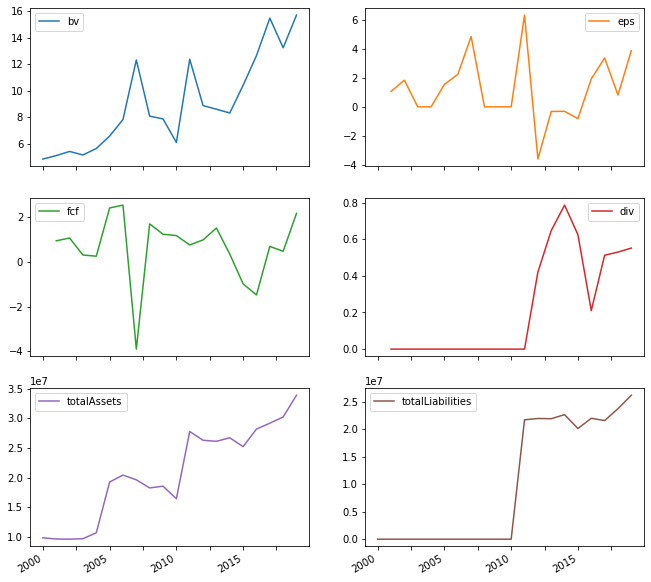

In [96]:
df_mgm[['bv','eps','fcf','div','totalAssets','totalLiabilities']].plot(subplots = True,
                                                                     figsize = (11,11),
                                                                        layout = (3,-1))

In [97]:
df_mgm[['pe','ps','pb']]

,pe,ps,pb
2000,NaN,NaN,2.065105
2001,9.345794,1.113957,1.959613
2002,5.405405,1.103235,1.846747
2003,inf,639.875146,1.941757
2004,inf,422.862054,1.775081
2005,6.410256,0.694506,1.520832
2006,4.444444,0.631034,1.278072
2007,2.049180,0.585877,0.811787
2008,inf,131.105604,1.237935
2009,inf,85.988430,1.271176


In [102]:
annual_growth(748324.0,581615.0,9)

0.028398806459696058

In [106]:
cf_mgm = [df_mgm.freeCashFlow.mean(),df_mgm.freeCashFlow.median()]
grs = [0.03,0.05]


In [107]:
intrinsic_cash(cf_mgm, grs,drs,lgr,df_mgm.shares.values[0],9)

defaultdict(list,
            {'318.11726315789474,3.0%': [9.178942432578173,
              5.3350190275010645,
              3.7771727799531325],
             '318.11726315789474,5.0%': [10.619751915033143,
              6.029770239232026,
              4.19586575802523],
             '465.81,3.0%': [13.440462589410187,
              7.811915607883282,
              5.530805952384556],
             '465.81,5.0%': [15.550198660819909,
              8.829219914867002,
              6.143886092015209]})

In [59]:
annual_growth(41242.0,24166.0,9)

0.061189078945135256

In [109]:
intrinsic_bk(0.3,9,0.03,0.15,9)

4.769556927525122

In [65]:
intrinsic_cash(cf_mgm, grs,drs,lgr,df_mgm.shares.values[0],9)

defaultdict(list,
            {'32.485,3.0%': [15.90213311708111,
              9.242696898977421,
              6.5437935572888195],
             '32.485,6.0%': [19.79581277105835,
              11.113255584259784,
              7.6672475242438285]})

In [69]:
intrinsic_bk(0.2,3,0.03,0.005,9)

5.498312027774887

In [110]:
annual_growth(32680,28000,4)

0.039395911384647375

In [111]:
intrinsic_cash([1800E03],[0.05,0.07],drs,lgr,1.5E06,5)

defaultdict(list,
            {'1800.0,5.0%': [18.586473994544917,
              10.572238856889635,
              7.354570904900046],
             '1800.0,7.000000000000001%': [20.484355622692107,
              11.54079034137165,
              7.96389131716384]})

In [113]:
intrinsic_bk(1,23,0.04,0.15,5)

17.264660012159084

In [114]:
annual_growth(42000,29000,4)

0.09701564967352727

# energy 
# whd 

In [229]:
dict_gm_cash,errs_gm = url_import(['GM'], 'cash-gmlow-statement')
dict_gm_balance,errs_gm = url_import(['GM'], 'balance-sheet-statement')
dict_gm_income,errs_gm = url_import(['GM'], 'income-statement')

https://fmpcloud.io/api/v3/cash-gmlow-statement/GM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/GM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/GM?apikey=cb3b0c371586d9ce915d359479fe1c81


In [230]:
dgm_gm_cash = pd.Datagmrame(dict_gm_cash)
dgm_gm_bal = pd.Datagmrame(dict_gm_balance)
dgm_gm_income = pd.Datagmrame(dict_gm_income)

AttributeError: module 'pandas' has no attribute 'Datagmrame'

In [231]:
dgm_gm_bal.date = dgm_gm_bal.date.map(lambda x: re.sub(r'-.*$','',x))
dgm_gm_cash.date = dgm_gm_cash.date.map(lambda x: re.sub(r'-.*$','',x))
dgm_gm_income.date = dgm_gm_income.date.map(lambda x: re.sub(r'-.*$','',x))

NameError: name 'dgm_gm_bal' is not defined

In [194]:
dgm_gm_bal.set_index(['date'], inplace = True)
dgm_gm_cash.set_index(['date'], inplace = True)
dgm_gm_income.set_index(['date'], inplace = True)

In [195]:
dgm_gm_cash.drop('netIncome',axis = 1, inplace = True)
dgm_gm_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [196]:
dgm_gm = pd.concat([dgm_gm_income,dgm_gm_bal,dgm_gm_cash],axis = 1)

In [197]:
dgm_gm.drop(['symbol','period'],axis = 1, inplace =True)

In [198]:
dgm_gm['shares'] = 3.9E09

In [199]:
dgm_gm.drop(['gmillingDate','gminalLink','link'],axis = 1,inplace = True)

In [200]:
dgm_gm = dgm_gm/1000

In [201]:
dgm_gm[['grossProgmitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBegmoreTaxRatio',
 'netIncomeRatio','eps']] = dgm_gm[['grossProgmitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBegmoreTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [202]:
dgm_gm = dgm_gm.sort_index()

In [203]:
dgm_gm_main = dgm_gm.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [204]:
dgm_gm_main['netIncome'] = dgm_gm_income['netIncome'] / 1000

In [205]:
dgm_gm = metrics(dgm_gm)
dgm_gm = price_ratios(dgm_gm, 4)

# ana

In [207]:
df_f.commonStockRepurchased

date
2003          0.0
2004          0.0
2005          0.0
2006          0.0
2007          0.0
2008          0.0
2009          0.0
2010          0.0
2011          0.0
2012          0.0
2013    -213000.0
2014   -1964000.0
2015    -129000.0
2016    -145000.0
2017    -131000.0
2018    -164000.0
2019    -237000.0
Name: commonStockRepurchased, dtype: float64

In [208]:
dgm_gm[['de','debtRatio']]

,de,debtRatio
date,,
2003,17.062141,1.647790
2004,11.868557,1.635696
2005,11.911091,1.355823
2006,-49.653391,1.402947
2007,29.944918,1.422326
2008,-8.935821,2.094766
2009,inf,1.117327
2010,inf,1.612683
2011,inf,1.265314


In [209]:
dgm_gm[['curr','intCov']]

,curr,intCov
date,,
2003,0.837136,1.117518
2004,0.812383,0.144963
2005,0.903356,-0.163418
2006,1.019383,-0.168280
2007,1.080151,-0.106251
2008,0.693888,0.077980
2009,1.095121,-0.774458
2010,0.995712,-inf
2011,1.162133,-0.186188


In [211]:
dgm_gm[['roe','rogm','rocgm','gmcgmRatio']]

,roe,rof,rocf,fcfRatio
date,,,,
2003,-0.179555,0.114668,0.114668,0.051875
2004,-0.068059,0.087130,0.087130,0.057019
2005,0.193563,0.419542,0.419542,0.030696
2006,3.580087,1.207792,1.207792,-0.026136
2007,-0.435679,1.550284,1.550284,0.050593
2008,0.835711,0.718618,0.718618,-0.085044
2009,inf,inf,inf,0.034579
2010,inf,inf,inf,0.049343
2011,inf,inf,inf,0.071802


In [181]:
annual_growth(3,1.3,9)

0.09737004302474705

In [214]:
annual_growth(0.6,0.4,6)

0.06991319393366302

In [212]:
dgm_gm[['bv','div']]

,bv,div
date,,
2003,2.987436,0.187949
2004,4.114103,0.187949
2005,3.322308,0.189231
2006,-0.888462,0.120000
2007,1.443077,0.000000
2008,-4.438718,0.000000
2009,0.000000,0.000000
2010,0.000000,0.000000
2011,0.000000,0.000000


In [216]:
annual_growth(7237000.0,3847000.0,6)

0.11106482284695285

In [224]:
cgm_gm = [8000000.0]
grs = [0.04,0.1]

In [187]:
cf_f = [df_f.freeCashFlow.median()]
grs = [0.05,0.08]

In [225]:
intrinsic_cash(cgm_gm, grs,drs,lgr,dgm_gm.shares.values[0],6)

defaultdict(list,
            {'8000.0,4.0%': [30.542479927521224,
              17.49506212955428,
              12.247639938388163],
             '8000.0,10.0%': [42.49084249084249,
              23.463431741483486,
              15.936172669164511]})

In [228]:
intrinsic_bk(0.6,7,0.06,0.15,6)

6.563544319247398

In [157]:
annual_growth(150,21,4)

0.6348126556655487

In [159]:
intrinsic_cash([100E03],[0.05,0.08],drs,lgr,df_oxy.shares.values[0],4)

defaultdict(list,
            {'100.0,5.0%': [20.30171576084594,
              11.532354164468867,
              8.0058043236826],
             '100.0,8.0%': [22.994462545866128,
              12.930002059915086,
              8.897032941176473]})

# auto

In [1718]:
dict_disc_cash,errs_t = url_import(['DISCA'], 'cash-flow-statement')
dict_disc_balance,errs_t = url_import(['DISCA'], 'balance-sheet-statement')
dict_disc_income,errs_t = url_import(['DISCA'], 'income-statement')
dict_disc_val, errs_t = url_import(['DISCA'], 'enterprise-values')

https://fmpcloud.io/api/v3/cash-flow-statement/DISCA?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/DISCA?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/DISCA?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/enterprise-values/DISCA?apikey=cb3b0c371586d9ce915d359479fe1c81


In [1719]:
df_disc_cash = pd.DataFrame(dict_disc_cash)
df_disc_bal = pd.DataFrame(dict_disc_balance)
df_disc_income = pd.DataFrame(dict_disc_income)
df_disc_val = pd.DataFrame(dict_disc_val)

In [1720]:
df_disc_bal.date = df_disc_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_disc_cash.date = df_disc_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_disc_income.date = df_disc_income.date.map(lambda x: re.sub(r'-.*$','',x))
df_disc_val.date = df_disc_val.date.map(lambda x: re.sub(r'-.*$','',x))

In [1721]:
df_disc_bal.set_index(['date'], inplace = True)
df_disc_cash.set_index(['date'], inplace = True)
df_disc_income.set_index(['date'], inplace = True)
df_disc_val.set_index(['date'], inplace = True)

In [1722]:
df_disc_cash.drop('netIncome',axis = 1, inplace = True)
df_disc_cash.rename({'inventory': 'inventoryCash',
                 'depreciationAndAmortization': 'deprCash'}, axis = 1, inplace = True)
df_disc_val.rename({'numberOfShares':'shares'}, axis = 1, inplace = True)

In [1723]:
df_disc_val.stockPrice.values[0] = 18

In [1724]:
df_disc = pd.concat([df_disc_income,df_disc_bal,df_disc_cash,df_disc_val],axis = 1)

In [1725]:
df_disc.drop(['symbol','period'],axis = 1, inplace =True)

In [1726]:
df_disc.drop(['fillingDate','finalLink','link','acceptedDate'],axis = 1,inplace = True)

In [1727]:
df_disc = df_disc/1E06

In [1728]:
df_disc[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps','stockPrice']] = df_disc[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps','stockPrice']] * 1E06

In [1729]:
df_disc = df_disc.sort_index()

In [1730]:
df_disc = metrics(df_disc)
df_disc = enterValue(df_disc)
df_disc = price_ratios(df_disc)
df_disc = earn_calc(df_disc)

In [1731]:
df_disc_ana = df_disc.copy()
df_disc_ana.index = pd.to_datetime(df_disc_ana.index)

# ana

In [1732]:
df_disc_ana = df_disc_ana.resample('3Y').agg(['mean','median','last'])

In [1733]:
df_disc_ana[['de','debtRatio','curr']]

de                     debtRatio                      \
                mean    median      last      mean    median      last   
date                                                                     
2008-12-31       inf       inf       inf  0.520226  0.520226  0.520226   
2011-12-31       inf  0.651373  0.651373  0.401634  0.356333  0.356333   
2014-12-31  1.053060  1.048903  1.276865  0.428679  0.433874  0.446672   
2017-12-31  2.053183  1.533385  3.207158  0.548628  0.502792  0.655509   
2020-12-31  1.795723  1.795723  1.558892  0.490359  0.490359  0.457062   

                curr                      
                mean    median      last  
date                                      
2008-12-31  1.267059  1.267059  1.267059  
2011-12-31  2.245321  2.210191  3.258713  
2014-12-31  1.901627  1.862442  0.956605  
2017-12-31  2.882987  1.664958  5.339925  
2020-12-31  1.334613  1.334613  1.610682

In [1734]:
df_disc.totalDebt

date
2008     4141.0
2009     4141.0
2010     3618.0
2011     4245.0
2012     5243.0
2013     6499.0
2014     7153.0
2015     7735.0
2016     7923.0
2017    14785.0
2018    17045.0
2019    15419.0
Name: totalDebt, dtype: float64

In [1735]:
df_disc_ana[['roe','rof','roc','fcfRatio']]

roe                           rof                      \
                mean    median      last      mean    median      last   
date                                                                     
2008-12-31       inf       inf       inf       inf       inf       inf   
2011-12-31       inf  0.173700  0.173700       inf  0.159890  0.159890   
2014-12-31  0.175572  0.173499  0.203320  0.188379  0.188832  0.213852   
2017-12-31  0.115890  0.189690 -0.073102  0.262715  0.248694  0.324078   
2020-12-31  0.147286  0.147286  0.223739  0.302038  0.302038  0.314427   

                 roc                      fcfRatio                      
                mean    median      last      mean    median      last  
date                                                                    
2008-12-31  0.255252  0.255252  0.255252  0.092361  0.092361  0.092361  
2011-12-31  0.201190  0.167162  0.167162  0.166850  0.164060  0.246045  
2014-12-31  0.159932  0.160829  0.161584  0.210124  0.211382  0.191221  
2017-12-31  0.114840  0.150538  0.036762  0.199589  0.197784  0.217372  
2020-12-31  0.097467  0.097467  0.118886  0.254623  0.254623  0.279074

In [1457]:
annual_growth(49,34,6)

0.06280321746772732

In [1736]:
df_disc_ana[['totalAssets','totalLiabilities']]

totalAssets                   totalLiabilities                  
                    mean   median     last             mean   median     last
date                                                                         
2008-12-31   7960.000000   7960.0   7960.0      5203.000000   5203.0   5203.0
2011-12-31  10297.333333  11019.0  11913.0      5131.000000   5203.0   5396.0
2014-12-31  14641.000000  14979.0  16014.0      8611.333333   8783.0  10412.0
2017-12-31  18059.000000  15864.0  22555.0     12983.000000  10591.0  17945.0
2020-12-31  33142.500000  33142.5  33735.0     22966.500000  22966.5  21769.0

In [1737]:
(df_disc.totalCurrentAssets - df_disc.totalLiabilities) / df_disc.shares

date
2008   -12.853583
2009    -9.754137
2010    -7.130536
2011    -7.394015
2012   -10.396277
2013   -17.851541
2014   -17.447137
2015   -18.094907
2016   -19.930175
2017   -20.713542
2018   -40.026104
2019   -31.289225
dtype: float64

In [1738]:
df_disc_ana[['rdpct','smpct','gapct']]

rdpct             smpct                 gapct                    
            mean median last  mean median last      mean    median      last
date                                                                        
2008-12-31   0.0    0.0  0.0   0.0    0.0  0.0  0.323845  0.323845  0.323845
2011-12-31   0.0    0.0  0.0   0.0    0.0  0.0  0.316026  0.314074  0.279339
2014-12-31   0.0    0.0  0.0   0.0    0.0  0.0  0.280782  0.284553  0.270072
2017-12-31   0.0    0.0  0.0   0.0    0.0  0.0  0.259461  0.260120  0.257238
2020-12-31   0.0    0.0  0.0   0.0    0.0  0.0  0.249225  0.249225  0.250179

In [1740]:
annual_growth(17,10,9)

0.060731425859614774

In [1739]:
df_disc_ana[['bv','div']]

bv                             div                    
                 mean     median       last      mean    median      last
date                                                                     
2008-12-31   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000
2011-12-31  10.254120  14.510490  16.251870  0.000777  0.000000  0.000000
2014-12-31  15.475444  16.731383  12.339207  0.000000  0.000000  0.000000
2017-12-31  12.502850  12.618056  12.005208  0.076737  0.078125  0.078125
2020-12-31  17.768450  17.768450  18.697543  0.076305  0.076305  0.000000